# Genre Collaboration Network (2000-2023)

Network visualization from BigQuery co-occurrence data.

In [357]:
# Load packages
library(tidyverse)
library(igraph)
library(GGally)
library(network)
library(sna)
library(intergraph)
library(patchwork)

theme_set(theme_minimal())

## Load Data

In [358]:
# Load co-occurrence network
edges_all <- read_csv(
  '../../data/sql_query_out/QUERY 2_ Genre Co-Occurrence Network (All Time).csv',
  show_col_types = FALSE
) %>%
  rename(from = genre_1, to = genre_2, weight = co_occurrence_count) %>%
  filter(from != to, weight >= 2)

cat(sprintf('%d genre connections loaded\n', nrow(edges_all)))

edges_all %>% arrange(desc(weight)) %>% head(10)

8597 genre connections loaded


from,to,weight
<chr>,<chr>,<dbl>
hip hop,rap,287
pop rap,rap,273
dance pop,pop,268
mellow gold,soft rock,243
album rock,rock,239
pop rap,southern hip hop,237
r&b,urban contemporary,224
hip hop,pop rap,218
rap,southern hip hop,213


In [359]:
# Load genre mapping
genre_mapping <- read_csv(
  '../../data/sql_query_out/QUERY 5_ Genre to Main Genre Mapping (For Node Coloring).csv',
  show_col_types = FALSE
) %>%
  mutate(primary_main_genre = tolower(trimws(primary_main_genre)))

cat(sprintf('%d subgenres mapped\n', nrow(genre_mapping)))

genre_mapping %>% count(primary_main_genre, sort = TRUE) %>% head(10)

1562 subgenres mapped


primary_main_genre,n
<chr>,<int>
alternative metal,70
alternative rock,44
alternative dance,43
album rock,36
dance pop,29
alternative country,22
latin,22
anthem worship,19
big room,18


## Build Network

In [360]:
# Build node list with macro genre mapping
all_genres <- unique(c(edges_all$from, edges_all$to))

# Load complete mapping (regex + manual assignments)
macro_mapping <- read_csv('../../data/cleaned/genre_network_mapping.csv', show_col_types = FALSE)

nodes <- tibble(name = all_genres) %>%
  left_join(genre_mapping %>% select(sub_genre, artist_count),
            by = c('name' = 'sub_genre')) %>%
  left_join(macro_mapping, by = c('name' = 'micro_genre')) %>%
  mutate(
    artist_count = ifelse(is.na(artist_count), 1, artist_count),
    macro_genre = ifelse(is.na(macro_genre), 'OTHER', macro_genre)
  )

cat(sprintf('%d nodes, %d edges\n', nrow(nodes), nrow(edges_all)))
cat('\nMacro genre distribution:\n')
nodes %>% count(macro_genre, sort = TRUE) %>% print(n = 20)

957 nodes, 8597 edges

Macro genre distribution:
# A tibble: 16 x 2
   macro_genre     n
   <chr>       <int>
 1 ROCK          239
 2 POP           129
 3 ELECTRONIC     93
 4 METAL          86
 5 HIP HOP        80
 6 R&B            62
 7 JAZZ           45
 8 LATIN          43
 9 OTHER          39
10 CLASSICAL      36
11 FOLK           33
12 COUNTRY        32
13 BLUES          17
14 REGGAE         11
15 NEW AGE         8
16 AVANT-GARDE     4


## Network Setup

In [361]:
# 16 macro genre colors
macro_genre_colors <- c(
  'POP' = '#f180a6ff',
  'ELECTRONIC' = '#d31f8eff',
  'R&B' = '#FF0800',
  'HIP HOP' = '#9D2A3A',
  'REGGAE' = '#FFB627',
  'LATIN' = '#E07B00',
  'BLUES' = '#1565C0',
  'JAZZ' = '#5C9CE6',
  'ROCK' = '#2832C2',
  'METAL' = '#1F456E',
  'FOLK' = '#6B8E4E',
  'COUNTRY' = '#7bac21ff',
  'CLASSICAL' = '#7B2D8E',
  'NEW AGE' = '#B57EDC',
  'AVANT-GARDE' = '#4A235A',
  'OTHER' = '#757575'
)

# Create igraph
g <- igraph::graph_from_data_frame(edges_all, directed = FALSE, vertices = nodes)

# Convert to network object
net <- intergraph::asNetwork(g)
net %v% "genre_name" <- nodes$name
net %v% "artist_count" <- nodes$artist_count
net %v% "macro_genre" <- nodes$macro_genre

# Layout
set.seed(42)
layout <- igraph::layout_with_fr(g, weights = 1/igraph::E(g)$weight, niter = 5000) * 1.5

## Hub Genres

In [362]:
# Calculate centrality
hub_metrics <- tibble(
  genre = nodes$name,
  main_genre = nodes$macro_genre,
  artists = nodes$artist_count,
  degree = igraph::degree(g),
  strength = igraph::strength(g),
  betweenness = igraph::betweenness(g, weights = 1/igraph::E(g)$weight)
) %>%
  arrange(desc(strength))

head(hub_metrics, 20)

# Bar chart
p_hubs <- ggplot(head(hub_metrics, 25), aes(x = reorder(genre, strength), y = strength, fill = main_genre)) +
  geom_col() +
  coord_flip() +
  labs(title = 'Top 25 Hub Genres', x = NULL, y = 'Collaboration Strength', fill = 'Genre') +
  scale_fill_manual(values = macro_genre_colors) +
  theme_minimal()

ggsave('../../outputs/genre_network/genre_hubs.png', p_hubs, width = 12, height = 10, dpi = 300, bg = 'white')

genre,main_genre,artists,degree,strength,betweenness
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
rock,ROCK,234,172,4062,162032.25
folk rock,ROCK,89,105,2846,45627.00
singer-songwriter,FOLK,54,140,2740,14171.00
modern rock,ROCK,62,153,2723,59555.43
mellow gold,POP,145,96,2591,33109.00
indie rock,ROCK,69,128,2517,16454.51
folk-pop,POP,46,145,2427,28311.01
classic rock,ROCK,172,95,2390,7482.00
hip hop,HIP HOP,94,79,2330,31245.00


In [363]:
# Full network visualization - FR layout with center scaling and collision detection
library(ggraph)

set.seed(42)

# Select top 15% of nodes by artist count for labels
label_threshold <- quantile(nodes$artist_count, 0.75)
nodes_for_plot <- nodes %>%
  mutate(
    # Wrap text - replace spaces with newlines for multi-word genres
    label = ifelse(artist_count >= label_threshold, 
                   str_replace_all(name, " ", "\n"), 
                   NA_character_)
  )

# Create fresh graph
g_full <- igraph::graph_from_data_frame(edges_all, directed = FALSE, vertices = nodes_for_plot)

# Calculate layout first, then scale it to spread nodes
layout_fr <- create_layout(g_full, layout = 'fr', weights = 1/E(g_full)$weight, niter = 10000)

# Scale coordinates outward from center
center_x <- mean(layout_fr$x)
center_y <- mean(layout_fr$y)
layout_fr$x <- center_x + (layout_fr$x - center_x) * 3.5
layout_fr$y <- center_y + (layout_fr$y - center_y) * 3.5

# Collision detection - push overlapping nodes apart
# Node radius proportional to artist_count
min_size <- 2
max_size <- 18
layout_fr$radius <- min_size + (max_size - min_size) * 
  (layout_fr$artist_count - min(layout_fr$artist_count)) / 
  (max(layout_fr$artist_count) - min(layout_fr$artist_count))

# Iterative collision resolution
for (iter in 1:50) {
  moved <- FALSE
  for (i in 1:(nrow(layout_fr) - 1)) {
    for (j in (i + 1):nrow(layout_fr)) {
      dx <- layout_fr$x[j] - layout_fr$x[i]
      dy <- layout_fr$y[j] - layout_fr$y[i]
      dist <- sqrt(dx^2 + dy^2)
      min_dist <- (layout_fr$radius[i] + layout_fr$radius[j]) * 0.35  # scale factor for plot units
      
      if (dist < min_dist && dist > 0) {
        # Push nodes apart
        overlap <- min_dist - dist
        pushx <- (dx / dist) * overlap * 0.5
        pushy <- (dy / dist) * overlap * 0.5
        
        layout_fr$x[i] <- layout_fr$x[i] - pushx
        layout_fr$y[i] <- layout_fr$y[i] - pushy
        layout_fr$x[j] <- layout_fr$x[j] + pushx
        layout_fr$y[j] <- layout_fr$y[j] + pushy
        moved <- TRUE
      }
    }
  }
  if (!moved) break
}
cat(sprintf("Collision resolution: %d iterations\n", iter))

p_full <- ggraph(layout_fr) +
  geom_edge_link(alpha = 0.05, color = "gray60") +
  geom_node_point(aes(color = macro_genre, size = artist_count), alpha = 0.8) +
  geom_node_text(aes(label = label), size = 1.2, color = "#ffffffff", fontface = "bold", lineheight = 0.8) +
  scale_color_manual(values = macro_genre_colors, name = "Genre") +
  scale_size_continuous(range = c(2, 18), name = "Artists") +
  labs(title = "Billboard Genre Network (2000-2023)",
       subtitle = sprintf("%d nodes, %d edges | Top 15%% labeled", vcount(g_full), ecount(g_full))) +
  theme_void() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 12, color = "gray40"),
    legend.position = "right",
    plot.margin = margin(20, 20, 20, 20)
  ) +
  coord_fixed(ratio = 1)

ggsave('../../outputs/genre_network/genre_network_full.png', p_full, 
       width = 28, height = 24, dpi = 300, bg = 'white')

cat(sprintf("Saved genre_network_full.png (%d nodes, %d edges)\n", vcount(g_full), ecount(g_full)))

Collision resolution: 50 iterations


Warning message:
"Removed 709 rows containing missing values or values outside the scale range
(`geom_text()`)."


Saved genre_network_full.png (957 nodes, 8597 edges)


## Yearly Networks

In [364]:
# Create network for a given year - FR layout with "pop" fixed at center
library(ggraph)

create_year_network_circular <- function(year_val) {
  file_path <- sprintf('../../data/sql_query_out/QUERY 4_ Export Individual Year Networks (Example for %d).csv', year_val)
  if (!file.exists(file_path)) return(NULL)
  
  edges_yr <- read_csv(file_path, show_col_types = FALSE) %>%
    rename(from = genre_1, to = genre_2, weight = co_occurrence_count) %>%
    filter(from != to, weight >= 2)
  
  if (nrow(edges_yr) == 0) return(NULL)
  
  genres_yr <- unique(c(edges_yr$from, edges_yr$to))
  nodes_yr <- nodes %>% filter(name %in% genres_yr)
  
  # Ensure "pop" is included
  if (!"pop" %in% nodes_yr$name) {
    pop_node <- nodes %>% filter(name == "pop")
    if (nrow(pop_node) > 0) {
      nodes_yr <- bind_rows(nodes_yr, pop_node)
    }
  }
  
  # Create graph with vertex attributes
  g_yr <- igraph::graph_from_data_frame(edges_yr, directed = FALSE, vertices = nodes_yr)
  
  # Set vertex attributes explicitly
  V(g_yr)$artist_count <- nodes_yr$artist_count[match(V(g_yr)$name, nodes_yr$name)]
  V(g_yr)$macro_genre <- nodes_yr$macro_genre[match(V(g_yr)$name, nodes_yr$name)]
  
  # Calculate FR layout
  set.seed(42)
  layout_mat <- igraph::layout_with_fr(g_yr, weights = 1/E(g_yr)$weight, niter = 5000)
  
  # Find "pop" and move it to center, shift all other nodes accordingly
  node_names <- V(g_yr)$name
  pop_idx <- which(node_names == "pop")
  
  if (length(pop_idx) > 0) {
    # Get pop's current position
    pop_x <- layout_mat[pop_idx, 1]
    pop_y <- layout_mat[pop_idx, 2]
    
    # Shift all nodes so pop is at origin
    layout_mat[, 1] <- layout_mat[, 1] - pop_x
    layout_mat[, 2] <- layout_mat[, 2] - pop_y
  }
  
  # Scale layout for better spread
  layout_mat <- layout_mat * 2
  
  # Create ggraph layout
  layout_df <- create_layout(g_yr, layout = 'manual', x = layout_mat[,1], y = layout_mat[,2])
  
  # Select top nodes for labels (by artist_count)
  label_threshold <- quantile(layout_df$artist_count, 0.7, na.rm = TRUE)
  layout_df$label <- ifelse(
    layout_df$artist_count >= label_threshold | layout_df$name == "pop",
    str_replace_all(layout_df$name, " ", "\n"),
    NA_character_
  )
  
  p <- ggraph(layout_df) +
    geom_edge_link(alpha = 0.1, color = "gray50") +
    geom_node_point(aes(color = macro_genre, size = artist_count), alpha = 0.85) +
    geom_node_text(aes(label = label), size = 2, color = "#333333", fontface = "bold", lineheight = 0.8) +
    scale_color_manual(values = macro_genre_colors, name = "Genre") +
    scale_size_continuous(range = c(2, 12), name = "Artists") +
    labs(title = as.character(year_val)) +
    theme_void() +
    theme(
      plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
      legend.position = "none"
    ) +
    coord_fixed(ratio = 1)
  
  return(p)
}

# Key years
key_years <- c(2000, 2005, 2010, 2015, 2020, 2023)
yearly_plots <- map(key_years, create_year_network_circular)
yearly_plots <- yearly_plots[!sapply(yearly_plots, is.null)]

if (length(yearly_plots) > 0) {
  combined <- wrap_plots(yearly_plots, ncol = 3) +
    plot_annotation(title = 'Genre Network Evolution (2000-2023)',
                    subtitle = 'Force-directed layout with POP anchored at center',
                    theme = theme(
                      plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
                      plot.subtitle = element_text(hjust = 0.5, size = 14, color = "gray40")
                    ))
  
  ggsave('../../outputs/genre_network/genre_network_evolution_key_years.png', combined,
         width = 28, height = 19, dpi = 300, bg = 'white')
  cat("Saved genre_network_evolution_key_years.png\n")
}

Warning message:
"Removed 31 rows containing missing values or values outside the scale range
(`geom_text()`)."
Warning message:
"Removed 31 rows containing missing values or values outside the scale range
(`geom_text()`)."
Warning message:
"Removed 25 rows containing missing values or values outside the scale range
(`geom_text()`)."
Warning message:
"Removed 27 rows containing missing values or values outside the scale range
(`geom_text()`)."
Warning message:
"Removed 17 rows containing missing values or values outside the scale range
(`geom_text()`)."
Warning message:
"Removed 12 rows containing missing values or values outside the scale range
(`geom_text()`)."


Saved genre_network_evolution_key_years.png


## Temporal Edges Export for Gephi

Create a single edges file with a year column so edges can be toggled on/off by year in Gephi.

In [365]:
# Create temporal edges file with year column for Gephi dynamic filtering
# Each unique edge pair (from, to) will have 24 rows - one per year (2000-2023)
# Weight = 0 if no connection that year, otherwise the co-occurrence count

# Load all yearly data files and combine
years <- 2000:2023

yearly_edges_list <- map(years, function(yr) {
  file_path <- sprintf('../../data/sql_query_out/QUERY 4_ Export Individual Year Networks (Example for %d).csv', yr)
  if (!file.exists(file_path)) return(NULL)
  
  read_csv(file_path, show_col_types = FALSE) %>%
    rename(from = genre_1, to = genre_2, weight = co_occurrence_count) %>%
    filter(from != to) %>%  # Remove self-loops
    mutate(year = yr)
})

yearly_edges <- bind_rows(yearly_edges_list)
cat(sprintf('Loaded %d yearly edge records\n', nrow(yearly_edges)))

# Get all unique edge pairs from the all-time network (these are canonical pairs)
all_edge_pairs <- edges_all %>%
  select(from, to) %>%
  # Ensure consistent ordering (alphabetical) to avoid duplicates
  mutate(
    genre_a = pmin(from, to),
    genre_b = pmax(from, to)
  ) %>%
  select(genre_a, genre_b) %>%
  distinct()

cat(sprintf('%d unique edge pairs in all-time network\n', nrow(all_edge_pairs)))

# Create full grid: all edge pairs × all years
temporal_grid <- expand_grid(
  all_edge_pairs,
  year = years
)

cat(sprintf('Grid size: %d edge pairs × %d years = %d rows\n', 
            nrow(all_edge_pairs), length(years), nrow(temporal_grid)))

# Normalize yearly edges to same ordering for matching
yearly_edges_normalized <- yearly_edges %>%
  mutate(
    genre_a = pmin(from, to),
    genre_b = pmax(from, to)
  ) %>%
  group_by(genre_a, genre_b, year) %>%
  summarize(weight = sum(weight), .groups = 'drop')

# Join to get weights (0 if no connection that year)
temporal_edges <- temporal_grid %>%
  left_join(yearly_edges_normalized, by = c('genre_a', 'genre_b', 'year')) %>%
  mutate(weight = ifelse(is.na(weight), 0, weight)) %>%
  rename(from = genre_a, to = genre_b)

# Summary stats
cat('\nTemporal edges summary:\n')
cat(sprintf('  Total rows: %d\n', nrow(temporal_edges)))
cat(sprintf('  Non-zero weights: %d (%.1f%%)\n', 
            sum(temporal_edges$weight > 0),
            100 * sum(temporal_edges$weight > 0) / nrow(temporal_edges)))

# Show weight distribution by year
temporal_edges %>%
  group_by(year) %>%
  summarize(
    edges_active = sum(weight > 0),
    total_weight = sum(weight),
    .groups = 'drop'
  ) %>%
  print(n = 24)

Loaded 8870 yearly edge records
8597 unique edge pairs in all-time network
Grid size: 8597 edge pairs <U+00D7> 24 years = 206328 rows

Temporal edges summary:
  Total rows: 206328
  Non-zero weights: 8035 (3.9%)
# A tibble: 24 x 3
    year edges_active total_weight
   <int>        <int>        <dbl>
 1  2000          348         1010
 2  2001          428         1258
 3  2002          417         1162
 4  2003          466         1511
 5  2004          451         1453
 6  2005          455         1598
 7  2006          383         1364
 8  2007          378         1331
 9  2008          347         1036
10  2009          331          942
11  2010          347          968
12  2011          375         1081
13  2012          305          736
14  2013          370          917
15  2014          432         1158
16  2015          454          969
17  2016          325          858
18  2017          257          756
19  2018          231          692
20  2019          174          415

In [366]:
# Export temporal edges (sparse - only weight > 0)
temporal_edges_export <- temporal_edges %>% filter(weight > 0) %>%
  select(from, to, weight, year) %>% arrange(from, to, year)

write_csv(temporal_edges_export, '../../outputs/genre_network/non_image/genre_network_edges_temporal_gephi.csv')
cat(sprintf('Exported: %d temporal edges\n', nrow(temporal_edges_export)))

Exported: 8035 temporal edges


In [367]:
# Export edges and nodes CSVs for Gephi
dir.create('../../outputs/genre_network/non_image', showWarnings = FALSE, recursive = TRUE)

edges_export <- edges_all %>% select(from, to, weight) %>% arrange(desc(weight))
write_csv(edges_export, '../../outputs/genre_network/non_image/genre_network_edges_gephi.csv')

nodes_export <- nodes %>%
  left_join(genre_mapping %>% select(sub_genre, primary_main_genre), by = c('name' = 'sub_genre')) %>%
  select(name, primary_main_genre, artist_count, macro_genre)
write_csv(nodes_export, '../../outputs/genre_network/non_image/genre_network_nodes_gephi.csv')

cat(sprintf('Exported: %d edges, %d nodes\n', nrow(edges_export), nrow(nodes_export)))

Exported: 8597 edges, 957 nodes


## GEXF Export for Gephi Dynamic Timeline

In [368]:
# Generate GEXF file for Gephi dynamic timeline
library(xml2)

node_positions <- tibble(name = layout_fr$name, x = layout_fr$x * 100, y = layout_fr$y * 100)

gexf <- xml_new_root("gexf", xmlns = "http://gexf.net/1.3", `xmlns:viz` = "http://gexf.net/1.3/viz", version = "1.3")
meta <- xml_add_child(gexf, "meta", lastmodifieddate = format(Sys.Date(), "%Y-%m-%d"))
xml_add_child(meta, "creator", "R/tidyverse")
xml_add_child(meta, "description", "Billboard Genre Network 2000-2023 with dynamic edges")

graph <- xml_add_child(gexf, "graph", mode = "dynamic", defaultedgetype = "undirected", timeformat = "double")

node_attrs <- xml_add_child(graph, "attributes", class = "node")
xml_add_child(node_attrs, "attribute", id = "macro_genre", title = "macro_genre", type = "string")
xml_add_child(node_attrs, "attribute", id = "artist_count", title = "artist_count", type = "integer")

edge_attrs <- xml_add_child(graph, "attributes", class = "edge")
xml_add_child(edge_attrs, "attribute", id = "weight", title = "weight", type = "double")

nodes_xml <- xml_add_child(graph, "nodes")
for (i in 1:nrow(nodes)) {
  node_name <- nodes$name[i]
  pos <- node_positions %>% filter(name == node_name)
  node <- xml_add_child(nodes_xml, "node", id = node_name, label = node_name)
  if (nrow(pos) > 0) xml_add_child(node, "viz:position", x = as.character(pos$x[1]), y = as.character(pos$y[1]), z = "0")
  color_hex <- macro_genre_colors[nodes$macro_genre[i]]
  if (!is.na(color_hex)) {
    r <- strtoi(substr(color_hex, 2, 3), 16)
    g <- strtoi(substr(color_hex, 4, 5), 16)
    b <- strtoi(substr(color_hex, 6, 7), 16)
    xml_add_child(node, "viz:color", r = as.character(r), g = as.character(g), b = as.character(b))
  }
  size_val <- 5 + (nodes$artist_count[i] / max(nodes$artist_count)) * 30
  xml_add_child(node, "viz:size", value = as.character(size_val))
  attvalues <- xml_add_child(node, "attvalues")
  xml_add_child(attvalues, "attvalue", `for` = "macro_genre", value = nodes$macro_genre[i])
  xml_add_child(attvalues, "attvalue", `for` = "artist_count", value = as.character(nodes$artist_count[i]))
}

edges_xml <- xml_add_child(graph, "edges")
active_edges <- temporal_edges %>% filter(weight > 0) %>%
  group_by(from, to) %>% summarize(years_active = list(year), weights = list(weight), .groups = 'drop')

edge_id <- 0
for (i in 1:nrow(active_edges)) {
  edge <- xml_add_child(edges_xml, "edge", id = as.character(edge_id), source = active_edges$from[i], target = active_edges$to[i])
  spells <- xml_add_child(edge, "spells")
  for (yr in active_edges$years_active[[i]]) xml_add_child(spells, "spell", start = as.character(yr), end = as.character(yr + 1))
  attvalues <- xml_add_child(edge, "attvalues")
  xml_add_child(attvalues, "attvalue", `for` = "weight", value = as.character(max(active_edges$weights[[i]])))
  edge_id <- edge_id + 1
}

write_xml(gexf, '../../outputs/genre_network/non_image/genre_network_dynamic.gexf')
cat(sprintf('Exported GEXF: %d nodes, %d edges\n', nrow(nodes), nrow(active_edges)))

Exported GEXF: 957 nodes, 1605 edges


## Animated Network

In [369]:
# Animated network - Top 300 nodes with collision detection and opacity filtering
library(gganimate)

nodes_filtered <- nodes %>% arrange(desc(artist_count)) %>% head(300)
edges_filtered <- edges_all %>% filter(from %in% nodes_filtered$name & to %in% nodes_filtered$name)
g_anim <- graph_from_data_frame(edges_filtered, directed = FALSE, vertices = nodes_filtered)

set.seed(42)
layout_anim <- layout_with_fr(g_anim, weights = 1 / E(g_anim)$weight, niter = 2000)

node_pos_anim <- tibble(name = V(g_anim)$name, x = layout_anim[,1], y = layout_anim[,2]) %>%
  left_join(nodes_filtered %>% select(name, macro_genre, artist_count), by = "name")

# Scale outward
center_x <- mean(node_pos_anim$x); center_y <- mean(node_pos_anim$y)
node_pos_anim <- node_pos_anim %>% mutate(x = center_x + (x - center_x) * 5.5, y = center_y + (y - center_y) * 5.5)

# Collision detection
min_size <- 3; max_size <- 15
node_pos_anim <- node_pos_anim %>% mutate(
  radius = min_size + (max_size - min_size) * (artist_count - min(artist_count)) / (max(artist_count) - min(artist_count))
)

for (iter in 1:100) {
  moved <- FALSE
  for (i in 1:(nrow(node_pos_anim) - 1)) {
    for (j in (i + 1):nrow(node_pos_anim)) {
      dx <- node_pos_anim$x[j] - node_pos_anim$x[i]
      dy <- node_pos_anim$y[j] - node_pos_anim$y[i]
      dist <- sqrt(dx^2 + dy^2)
      min_dist <- (node_pos_anim$radius[i] + node_pos_anim$radius[j]) * 0.55
      if (dist < min_dist && dist > 0) {
        overlap <- min_dist - dist
        node_pos_anim$x[i] <- node_pos_anim$x[i] - (dx/dist) * overlap * 0.5
        node_pos_anim$y[i] <- node_pos_anim$y[i] - (dy/dist) * overlap * 0.5
        node_pos_anim$x[j] <- node_pos_anim$x[j] + (dx/dist) * overlap * 0.5
        node_pos_anim$y[j] <- node_pos_anim$y[j] + (dy/dist) * overlap * 0.5
        moved <- TRUE
      }
    }
  }
  if (!moved) break
}

node_pos_anim <- node_pos_anim %>% mutate(label = str_replace_all(name, " ", "\n"))
filtered_node_names <- node_pos_anim$name

anim_edges <- temporal_edges %>% filter(weight > 0, from %in% filtered_node_names, to %in% filtered_node_names) %>%
  left_join(node_pos_anim %>% select(name, x, y), by = c('from' = 'name')) %>% rename(x_from = x, y_from = y) %>%
  left_join(node_pos_anim %>% select(name, x, y), by = c('to' = 'name')) %>% rename(x_to = x, y_to = y) %>%
  filter(!is.na(x_from) & !is.na(x_to))

# Activity status per year
active_nodes_by_year <- bind_rows(
  anim_edges %>% select(year, genre = from),
  anim_edges %>% select(year, genre = to)
) %>% distinct() %>% mutate(is_active = TRUE)

node_pos_yearly <- expand_grid(node_pos_anim %>% select(name, x, y, macro_genre, artist_count, label), year = 2000:2023) %>%
  left_join(active_nodes_by_year, by = c("name" = "genre", "year")) %>%
  mutate(is_active = ifelse(is.na(is_active), FALSE, TRUE), node_alpha = ifelse(is_active, 0.9, 0.15))

p_anim <- ggplot() +
  geom_segment(data = anim_edges, aes(x = x_from, y = y_from, xend = x_to, yend = y_to), alpha = 0.25, color = "gray40", linewidth = 0.4) +
  geom_point(data = node_pos_yearly, aes(x = x, y = y, color = macro_genre, size = artist_count, alpha = node_alpha)) +
  geom_text(data = node_pos_yearly %>% filter(is_active), aes(x = x, y = y, label = label), size = 1.5, color = "white", fontface = "bold", lineheight = 0.8) +
  scale_color_manual(values = macro_genre_colors, name = "Genre") +
  scale_size_continuous(range = c(3, 15), guide = "none") +
  scale_alpha_identity() +
  labs(title = 'Billboard Genre Network: {closest_state}', subtitle = sprintf("%d genres | Bright = active, Faded = inactive", nrow(node_pos_anim))) +
  theme_void() +
  theme(plot.title = element_text(hjust = 0.5, size = 32, face = "bold"), plot.subtitle = element_text(hjust = 0.5, size = 16, color = "gray40"),
        legend.position = "right", plot.background = element_rect(fill = "white", color = NA), plot.margin = margin(40, 40, 40, 40)) +
  coord_fixed(ratio = 1) +
  transition_states(year, transition_length = 0, state_length = 1) + enter_appear() + exit_disappear()

anim <- animate(p_anim, nframes = 24, fps = 1/3, width = 2400, height = 2000, res = 150, renderer = gifski_renderer())
anim_save('../../outputs/genre_network/genre_network_animated.gif', anim)
cat('Saved: genre_network_animated.gif\n')

Saved: genre_network_animated.gif


## Genre Collaboration Totals

In [370]:
# Total collaborations across all years (2000-2023)
genre_totals <- temporal_edges %>% filter(weight > 0) %>%
  pivot_longer(cols = c(from, to), names_to = "role", values_to = "genre") %>%
  group_by(genre) %>% summarize(total_collaborations = sum(weight), .groups = 'drop') %>%
  left_join(nodes %>% select(name, macro_genre), by = c('genre' = 'name')) %>%
  filter(!is.na(macro_genre), macro_genre != 'OTHER') %>%
  arrange(desc(total_collaborations))

cat(sprintf('Analyzed %d genres\n', nrow(genre_totals)))
genre_totals %>% head(20)

Analyzed 266 genres


genre,total_collaborations,macro_genre
<chr>,<dbl>,<chr>
pop,3919,POP
dance pop,3648,POP
pop rap,3636,POP
rap,2901,HIP HOP
hip hop,2651,HIP HOP
southern hip hop,2179,HIP HOP
trap music,1806,HIP HOP
urban contemporary,1769,R&B
r&b,1620,R&B


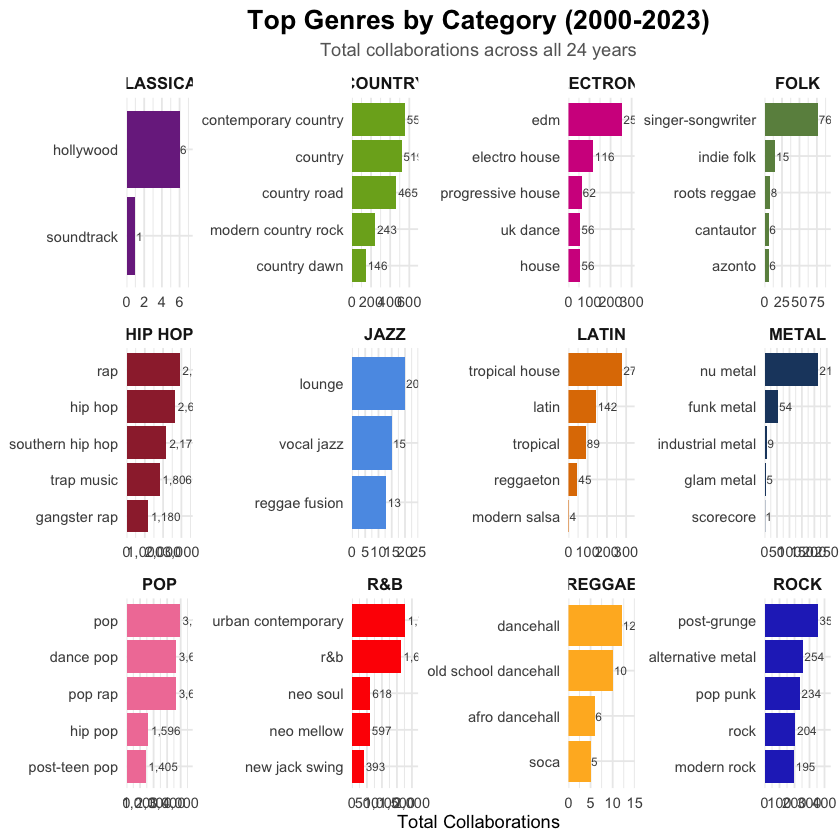

In [371]:
# Top genres by category
top5_by_macro <- genre_totals %>% group_by(macro_genre) %>%
  slice_max(order_by = total_collaborations, n = 5, with_ties = FALSE) %>% ungroup()

p_by_category <- ggplot(top5_by_macro, aes(x = reorder(genre, total_collaborations), y = total_collaborations, fill = macro_genre)) +
  geom_col(show.legend = FALSE) +
  geom_text(aes(label = scales::comma(total_collaborations)), hjust = -0.1, size = 2.5, color = "gray30") +
  coord_flip() + facet_wrap(~macro_genre, scales = "free", ncol = 4) +
  scale_fill_manual(values = macro_genre_colors) +
  scale_y_continuous(labels = scales::comma, expand = expansion(mult = c(0, 0.25))) +
  labs(title = "Top Genres by Category (2000-2023)", subtitle = "Total collaborations across all 24 years", x = NULL, y = "Total Collaborations") +
  theme_minimal() + theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 11, color = "gray40"), strip.text = element_text(face = "bold", size = 10))

ggsave('../../outputs/genre_network/top_genres_by_category.png', p_by_category, width = 16, height = 14, dpi = 300, bg = 'white')
print(p_by_category)

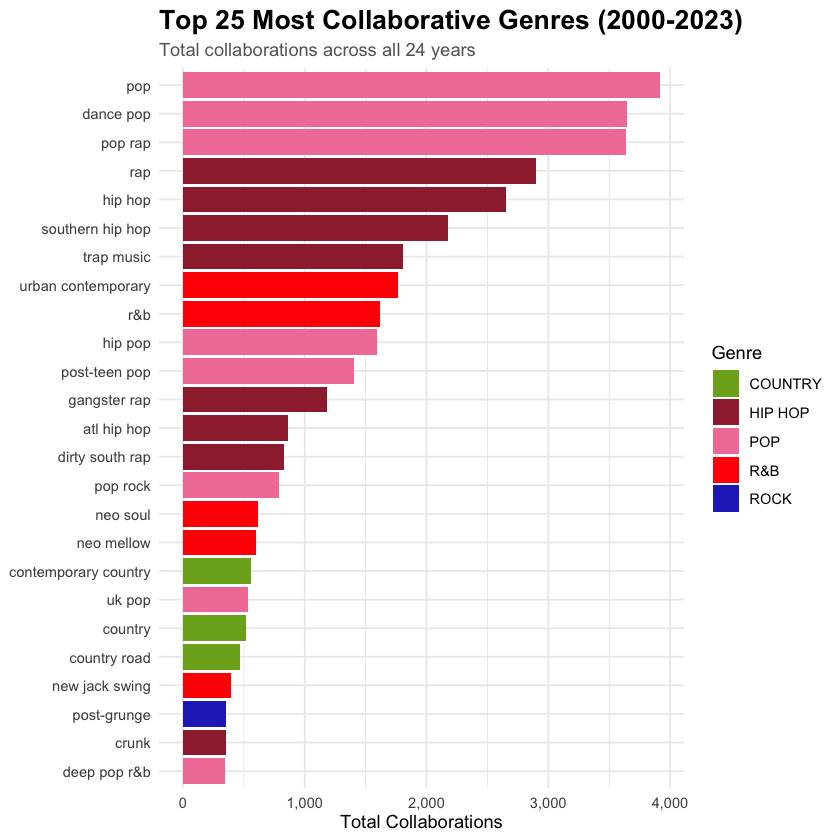

In [372]:
# Top 25 overall
top25_overall <- genre_totals %>% head(25)

p_top25 <- ggplot(top25_overall, aes(x = reorder(genre, total_collaborations), y = total_collaborations, fill = macro_genre)) +
  geom_col() + coord_flip() +
  scale_fill_manual(values = macro_genre_colors, name = "Genre") +
  scale_y_continuous(labels = scales::comma) +
  labs(title = "Top 25 Most Collaborative Genres (2000-2023)", subtitle = "Total collaborations across all 24 years", x = NULL, y = "Total Collaborations") +
  theme_minimal() + theme(plot.title = element_text(hjust = 0, size = 16, face = "bold"),
    plot.subtitle = element_text(hjust = 0, size = 11, color = "gray40"), legend.position = "right")

ggsave('../../outputs/genre_network/top_25_collaborative_genres.png', p_top25, width = 14, height = 12, dpi = 300, bg = 'white')
print(p_top25)